# Autodifferentiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

So far we have while performing the gradient descent we have used analitically derived formulas for the gradient. This is clearly impractical for larger systems. The core functionality of all of the neural networks libraries are *autodiferentiation* capabilities. We will explore them using a poipular PyTorch library. 

We start by laoding and visualising same example as in the gradient descent:

In [2]:
data = np.load("sgd_data.npy").astype('float32')
rxs = data[:50,0]
rys = data[:50,1]

Please note that we have explicitely changed the type to `float32`. This is a good practice when training neural networks. First the data will take less memory and second this will enable training on GPUs in the future. 

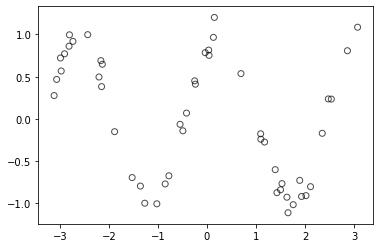

In [3]:
plt.scatter(rxs,rys, alpha=0.7, color='none', edgecolor="black");

$$f(x|\omega, t) = \sin(\omega x +t)$$

$$MSE(\omega,t|\textbf{x},\textbf{y}) = \frac{1}{2}\frac{1}{N}\sum_{i=1}^N \left(y_i-f(x_i|\omega, t)\right)^2 $$

In [4]:
def mse(f, x, y, o, t):
        err = f(x,o,t)-y
        return 0.5*np.sum(err*err, axis=-1)/len(x)
def fitf_tensor(x,o,t):
    return np.moveaxis(np.sin(np.tensordot(np.atleast_1d(x),o,0)+t),0,-1)

In [5]:
grid_size = 500
os = np.linspace(0, 2*np.pi, grid_size)
ts = np.linspace(-np.pi,np.pi,grid_size)
otg = np.meshgrid(os,ts)



vg = mse(fitf_tensor, rxs, rys, otg[0], otg[1])

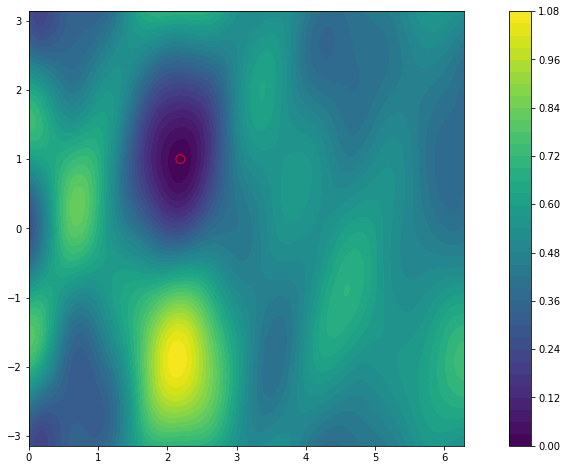

In [6]:
from matplotlib import gridspec

fig = plt.figure(figsize=(9,8))
gs=gridspec.GridSpec(1,2, width_ratios=[4,0.2])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
cs=ax1.contourf(otg[0], otg[1],vg, levels=40);
fig.colorbar(cs, cax=ax2);
ax1.scatter([2.188], [1],c='none', s=80, edgecolor='red');

We will be using the [PyTorch](https://pytorch.org) package which is the second (and risig fast) popular neural network librarie.  

In [7]:
import torch 

Torch has its own implementation of tensors and before use we have convert `numpy` arrays to torch tensors.

In [8]:
t_rxs = torch.from_numpy(rxs)
t_rys = torch.from_numpy(rys)

## Gradient Descent

We will now create the tensors for parameters to be optimized: `o` and `t`.

In [9]:
o = torch.FloatTensor([3]) # One dimensional tensor of length 1 with value  3.0
t = torch.FloatTensor([1]) # One dimensional tensor of length 1 with value  1.0

The `torch` module has the ability to track the gradients of the functions. To this end we must mark the variables with respect to which the derivatives will be taken. In our case we want derivatives with respect to `o` and `t`. We do it be setting the `requires_grad` attribute of those tensors. 

In [10]:
o.requires_grad_(True)
t.requires_grad_(True);

Now PyTorch will track the gradients with respect to `o` and `t` for every expression which  contains those variables. And we can use it to make our gradient descent: 

In [11]:
fig, ax =  plt.subplots(figsize=(8,8))
ax.contourf(otg[0], otg[1],vg, levels=20)
p = [o.item(), t.item()]
ax.scatter([p[0]], [p[1]],c='none', s=20, edgecolor='red')
eta = 0.1
trajectory_list=[]
n_iter = 50
for i in range(n_iter):
    if not ( o.grad is None):
        o.grad.data.zero_()
    if not ( t.grad is None):
        t.grad.data.zero_()
        
    prediction = torch.sin(t_rxs*o+t)
    residual = t_rys-prediction;
    loss = 0.5*torch.mean(residual*residual)
    loss.backward()
    o.data.sub_(eta*o.grad)
    t.data.sub_(eta*t.grad)
    p =  [o.item(), t.item()]
 
    ax.scatter(p[0:1], p[1:],c='red', s=20, edgecolor='red')
    plt.close()


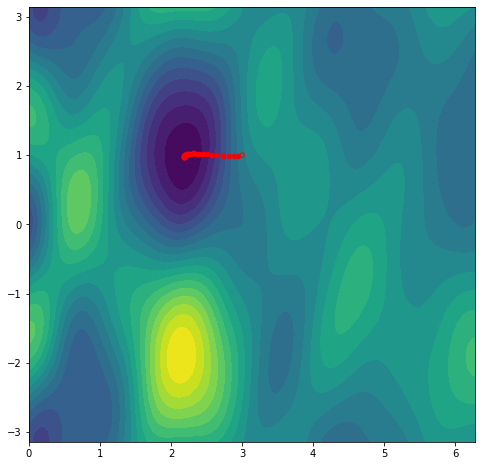

In [12]:
fig

So let's look closely at the core loop:

In [13]:
for i in range(n_iter):
    if not ( o.grad is None):
        o.grad.data.zero_()
    if not ( t.grad is None):
        t.grad.data.zero_()
        
    prediction = torch.sin(t_rxs*o+t)
    residual = t_rys-prediction;
    loss = 0.5*torch.mean(residual*residual)
    loss.backward()
    o.data.sub_(eta*o.grad)
    t.data.sub_(eta*t.grad)    

We start by zeroing the gradients because default behaviour is to accumulate them. However at the begining the object that holds gradients does not exists so we have to check for that.

Next we just calculate the loss and call `backward` on it. This function traverse the *computations graph* backward and calculates gradients. Then the `grad` attribute of `o` and `t` contains the gradient of loss with respect to `o` and `t`.

 We substract those gradients from the values of `o` and `t` using method `sub_`. By convention  methods tha modify the object in place have names that end in `_`. Another technical detail is that we are not allowed to modify in place a variable that requires grad, as this could potentially disrupt the  gradient calculations. That's why we do it by using the `data` attribute that holds reference to underlying tensor. 

All this magic depends on so called "computations graph" which describes all the computations done while calculating the loss. Below is a visualisation of actula  computation graph in this case. 

<p style="text-align:center;"><img src='call_graph.svg' /></p>

This can be written as a series of operations:

$$v_0 = \frac{1}{2} v_1 \qquad v_1 = \operatorname{mean}(v_2)$$

$$v_2 = v_3 \cdot v_4
\qquad
v_3 = y - v_5$$

$$v_4 = y - v_5\qquad v_5=\sin(v_6)$$

$$v_6= v_7 + v_8\qquad v_7 = o*x $$

$$v_8 = t$$

$$\frac{d v_0}{d t}=\frac{d v_0}{d v_1}\frac{d v_1}{d t} $$

$$\frac{d v_0}{d v_1}=\frac{1}{2}$$

then  again

$$\frac{d v_1}{d t}=\frac{d v_1}{d v_2}\frac{d v_2}{d t}=\sum_i \frac{d v_1}{d v_{2i}}\frac{d v_{2i}}{d t}$$

$$v_1 = \frac{1}{N}\sum_{i=1}^N v_{2i}$$

$$\frac{d v_1}{d v_{2i}}=\frac{1}{N}$$

and again

$$\frac{d v_{2i}}{d t} = \sum_{j}\frac{d v_{2i}}{d v_{3j}}\frac{d v_{3j}}{d t}+\sum_{j}\frac{d v_{2i}}{d v_{4j}}\frac{d v_{4j}}{d t}$$

$$\frac{d v_{2i}}{d v_{3j}} = \delta_{ij} v_{4j}$$

$$\frac{d v_{2i}}{d v_{4j}} = \delta_{ij} v_{3j}$$

$$\frac{d v_{3i}}{d t}=
\sum_{j}
\frac{d v_{3i}}{d v_{5j}}\frac{d v_{5j}}{d t}$$

$$\frac{d v_{4i}}{d t}=
\sum_{j}
\frac{d v_{4i}}{d v_{5j}}\frac{d v_{5j}}{d t}$$

$$\frac{d v_{3i}}{d v_{5j}}=\frac{d v_{4i}}{d v_{5j}}=-1$$

$$\frac{d v_{5i}}{d t}=\sum_{j}\frac{d v_{5i}}{d v_{6j}}\frac{d v_{6j}}{d t}$$

$$\frac{d v_{5i}}{d v_{6j}}=\delta_{ij} \cos(v_{6j})$$

$$\frac{d v_{6i}}{d t}=\sum_j \frac{d v_{6j}}{d v_{7j}}\frac{d v_{7j}}{d t}
+ \sum_j \frac{d v_{6j}}{d v_{8j}}\frac{d v_{8j}}{d t}
$$

$$\frac{d v_{7j}}{d t}  = 0$$

$$\frac{d v_{8j}}{d t}  = 1$$

What is important is that at every stage we need only the local values of the gradient and the variables at the given graph node. The final gradient is obtain by multiplying all the gradienst  going backward through the graph. 

## Optimizer

Finally let's add one more improvement. So far we were using a very simple gradient descent strategy. This will change and to this end PyTorch encapsulates the gradient step in separate object called *optimizer*.

In [14]:
o = torch.FloatTensor([3])
t = torch.FloatTensor([1])
o.requires_grad_(True)
t.requires_grad_(True);

In [15]:
optim = torch.optim.SGD([o,t],lr=0.1)

SGD stands for "Stochastic Gradient Descent". The "stochastic" part will be explained later, but actually it just does the plain gradient descent. The parameter `lr`(learning rate)  is our `eta`> 

In [16]:
fig, ax =  plt.subplots(figsize=(8,8))
ax.contourf(otg[0], otg[1],vg, levels=20)
p = [o.item(), t.item()]
ax.scatter([p[0]], [p[1]],c='none', s=20, edgecolor='red')
n_iter = 50
for i in range(n_iter):
    optim.zero_grad()
        
    prediction = torch.sin(t_rxs*o+t)
    residual = t_rys-prediction;
    loss = 0.5*torch.mean(residual*residual)
    loss.backward()
    optim.step()
    p =  [o.item(), t.item()]
 
    ax.scatter(p[0:1], p[1:],c='red', s=20, edgecolor='red')
    plt.close()


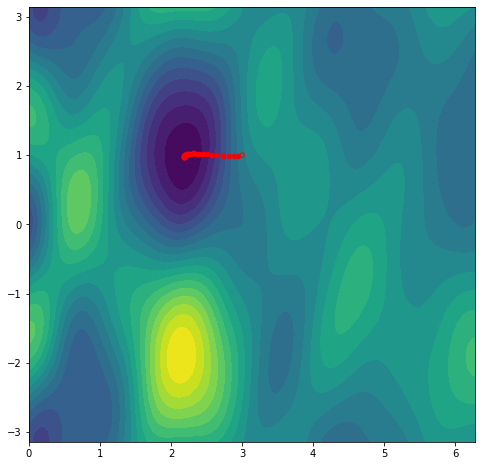

In [17]:
fig

## Loss function

We also do not have to write our own loss functions:

In [18]:
o = torch.FloatTensor([3])
t = torch.FloatTensor([1])
o.requires_grad_(True)
t.requires_grad_(True);

In [19]:
loss_f = torch.nn.MSELoss()

In [20]:
optim = torch.optim.SGD([o,t],lr=0.1)

In [21]:
fig, ax =  plt.subplots(figsize=(8,8))
ax.contourf(otg[0], otg[1],vg, levels=20)
p = [o.item(), t.item()]
ax.scatter([p[0]], [p[1]],c='none', s=20, edgecolor='red')
n_iter = 50
for i in range(n_iter):
    optim.zero_grad()
        
    prediction = torch.sin(t_rxs*o+t)
    loss = loss_f(prediction, t_rys)
    loss.backward()
    optim.step()
    p =  [o.item(), t.item()]
 
    ax.scatter(p[0:1], p[1:],c='red', s=20, edgecolor='red')
    plt.close()


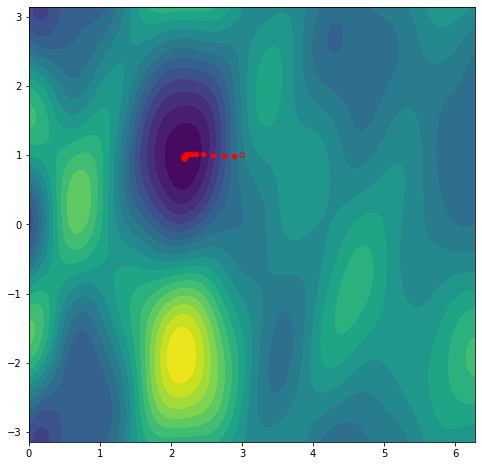

In [22]:
fig

As you can see thare is a slight difference, the steps seem to be longer. That's because the `MSELoss` does not contain the one half factor, so the gradient is twice as long.  